## Background

You are developing an NGS-based assay for a recently characterized disorder called Deldupemia, an autosomal recessive disease caused by mutations in the CNSL gene. Due to high sequence homology in the CNSL region, deletions and duplications are common (thus, rather than all patients having two copies of DNA across the region, **some have one, and others have three**). The deletion/duplication breakpoints can vary from sample to sample (see table further below), and it has been **hypothesized that the breakpoints correspond with ethnicity**.

With help from someone on the molecular biology team, you developed probes for the CNSL region and performed a retrospective analysis of 10,000 Myriad Women’s Health samples spanning different ethnicities. The data in “cnsl_data.csv.gz” catalogs the depth of NGS reads at 100 different hybrid capture probe locations, 50 in the CNSL region, and 50 outside of the region. The depth at a probe is expected to be linearly proportional to the copy number of the DNA at that site (i.e., having three CNSL copies should give roughly 3x the depth as having one copy).

## Assumptions

- Probes in the “nonCNSL” region are expected to have CN=2.
- A deletion or duplication is any contiguous stretch of at least four well behaved probes
that have copy number of ~1 or ~3, respectively.
- Due to variability of extraction efficiency in the lab and error in the quantification of DNA
libraries, each sample has a slightly different average NGS read depth across all probes.
- Each probe captures DNA with different efficiency relative to other probes, but you can
assume that a single probe is equally efficient across all samples.
- The breakpoint positions are known in the literature and correspond to the following
probe locations
    - 32-38
    - 27-34
    - 20-40
    - 10-40


## Task

- Write code to characterize the deletion and duplication frequencies and breakpoint positions on a per-ethnicity basis. 
- Your algorithm for finding deletions and duplications may use hardcoded breakpoints based on the table above, or be general. 
- Help the lab identify any problematic probes that may need redesigning.

## Steps

- Because each sample has a slightly different average NGS read depth across all probes, and probes in the “nonCNSL” region are expected to have CN=2, we can use the read depth of the "nonCNSL" region to normalize all samples.


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [7]:
cnsl_data = pd.read_csv('cnsl_data.csv.gz', index_col=[0])

In [8]:
cnsl_data

,ethnicity,CNSL_probe_0,CNSL_probe_1,CNSL_probe_2,CNSL_probe_3,CNSL_probe_4,CNSL_probe_5,CNSL_probe_6,CNSL_probe_7,CNSL_probe_8,...,non_CNSL_probe_40,non_CNSL_probe_41,non_CNSL_probe_42,non_CNSL_probe_43,non_CNSL_probe_44,non_CNSL_probe_45,non_CNSL_probe_46,non_CNSL_probe_47,non_CNSL_probe_48,non_CNSL_probe_49
0,A,410,233,697,167,131,77,520,132,161,...,578,186,232,1202,260,602,236,179,592,415
1,C,557,304,956,208,138,106,678,173,218,...,789,178,322,1630,314,780,334,218,708,582
2,A,487,260,861,194,148,94,617,191,205,...,761,205,335,1440,287,744,297,211,694,520
3,B,686,368,1276,267,221,1114,884,206,273,...,1035,309,415,2109,375,1008,441,315,1042,692
4,C,677,348,1248,267,179,268,856,225,305,...,947,252,385,1949,362,986,392,299,881,673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,A,523,292,942,215,141,48,634,172,217,...,752,213,282,1456,292,680,297,243,717,521
9996,A,1036,496,1883,364,313,81,1313,331,378,...,1447,418,581,3017,581,1484,637,397,1407,1083
9997,C,847,430,1541,368,250,719,1026,306,340,...,1237,308,455,2577,489,1277,551,374,1247,874
9998,B,1013,606,1819,434,306,29,1281,382,455,...,1406,422,597,3117,592,1451,601,478,1458,1015


In [14]:
cnsl_data.iloc[[1]]

,ethnicity,CNSL_probe_0,CNSL_probe_1,CNSL_probe_2,CNSL_probe_3,CNSL_probe_4,CNSL_probe_5,CNSL_probe_6,CNSL_probe_7,CNSL_probe_8,...,non_CNSL_probe_40,non_CNSL_probe_41,non_CNSL_probe_42,non_CNSL_probe_43,non_CNSL_probe_44,non_CNSL_probe_45,non_CNSL_probe_46,non_CNSL_probe_47,non_CNSL_probe_48,non_CNSL_probe_49
1,C,557,304,956,208,138,106,678,173,218,...,789,178,322,1630,314,780,334,218,708,582


In [9]:
list(cnsl_data)

['ethnicity',
 'CNSL_probe_0',
 'CNSL_probe_1',
 'CNSL_probe_2',
 'CNSL_probe_3',
 'CNSL_probe_4',
 'CNSL_probe_5',
 'CNSL_probe_6',
 'CNSL_probe_7',
 'CNSL_probe_8',
 'CNSL_probe_9',
 'CNSL_probe_10',
 'CNSL_probe_11',
 'CNSL_probe_12',
 'CNSL_probe_13',
 'CNSL_probe_14',
 'CNSL_probe_15',
 'CNSL_probe_16',
 'CNSL_probe_17',
 'CNSL_probe_18',
 'CNSL_probe_19',
 'CNSL_probe_20',
 'CNSL_probe_21',
 'CNSL_probe_22',
 'CNSL_probe_23',
 'CNSL_probe_24',
 'CNSL_probe_25',
 'CNSL_probe_26',
 'CNSL_probe_27',
 'CNSL_probe_28',
 'CNSL_probe_29',
 'CNSL_probe_30',
 'CNSL_probe_31',
 'CNSL_probe_32',
 'CNSL_probe_33',
 'CNSL_probe_34',
 'CNSL_probe_35',
 'CNSL_probe_36',
 'CNSL_probe_37',
 'CNSL_probe_38',
 'CNSL_probe_39',
 'CNSL_probe_40',
 'CNSL_probe_41',
 'CNSL_probe_42',
 'CNSL_probe_43',
 'CNSL_probe_44',
 'CNSL_probe_45',
 'CNSL_probe_46',
 'CNSL_probe_47',
 'CNSL_probe_48',
 'CNSL_probe_49',
 'non_CNSL_probe_0',
 'non_CNSL_probe_1',
 'non_CNSL_probe_2',
 'non_CNSL_probe_3',
 'non_CNSL_p

In [11]:
cnsl_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 101 entries, ethnicity to non_CNSL_probe_49
dtypes: float64(31), int64(69), object(1)
memory usage: 7.8+ MB


In [12]:
cnsl_data.ethnicity.value_counts()

A    4988
B    2543
C    2469
Name: ethnicity, dtype: int64

In [13]:
cnsl_data.CNSL_probe_0.describe()

count    10000.00000
mean       739.32180
std        258.30989
min        261.00000
25%        517.00000
50%        741.00000
75%        963.00000
max       1369.00000
Name: CNSL_probe_0, dtype: float64

We can first do some brief visualization to get a general idea about the data.

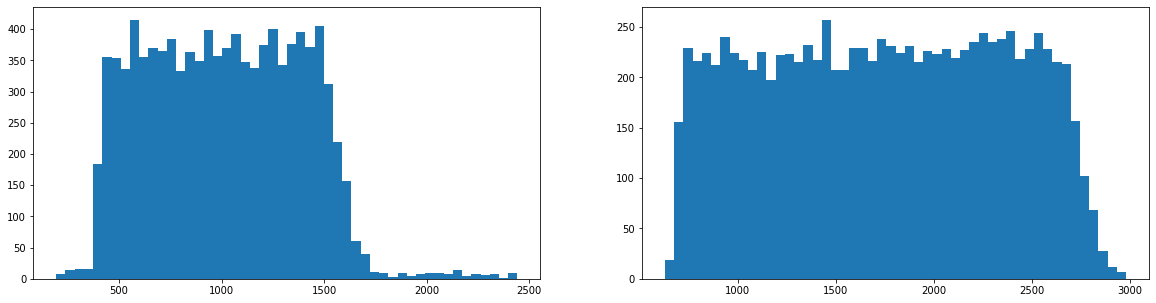

In [30]:
# get a general idea of the distribution of the reads

plt.figure(figsize = [20, 5]) 

plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 1
# for the distribution of a probe in the CNSL region
plt.hist(cnsl_data['CNSL_probe_33'], bins = 50);

plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
# for the distribution of a probe in the nonCNSL region
plt.hist(cnsl_data['non_CNSL_probe_33'], bins = 50);

In [32]:
cnsl_data.iloc[3, 51:]

non_CNSL_probe_0      334
non_CNSL_probe_1      799
non_CNSL_probe_2      218
non_CNSL_probe_3      995
non_CNSL_probe_4     1938
non_CNSL_probe_5      184
non_CNSL_probe_6     1281
non_CNSL_probe_7      305
non_CNSL_probe_8      647
non_CNSL_probe_9      928
non_CNSL_probe_10     690
non_CNSL_probe_11     273
non_CNSL_probe_12     321
non_CNSL_probe_13    1208
non_CNSL_probe_14     372
non_CNSL_probe_15     548
non_CNSL_probe_16     754
non_CNSL_probe_17     849
non_CNSL_probe_18     626
non_CNSL_probe_19     582
non_CNSL_probe_20     431
non_CNSL_probe_21     813
non_CNSL_probe_22     176
non_CNSL_probe_23     166
non_CNSL_probe_24     484
non_CNSL_probe_25     700
non_CNSL_probe_26     300
non_CNSL_probe_27     858
non_CNSL_probe_28     928
non_CNSL_probe_29     773
non_CNSL_probe_30     460
non_CNSL_probe_31    2494
non_CNSL_probe_32     621
non_CNSL_probe_33    1690
non_CNSL_probe_34    1200
non_CNSL_probe_35     834
non_CNSL_probe_36     717
non_CNSL_probe_37     451
non_CNSL_pro

In [34]:
cnsl_data.iloc[3, 1:51]

CNSL_probe_0      686
CNSL_probe_1      368
CNSL_probe_2     1276
CNSL_probe_3      267
CNSL_probe_4      221
CNSL_probe_5     1114
CNSL_probe_6      884
CNSL_probe_7      206
CNSL_probe_8      273
CNSL_probe_9      830
CNSL_probe_10    1170
CNSL_probe_11     218
CNSL_probe_12    1837
CNSL_probe_13     181
CNSL_probe_14     369
CNSL_probe_15    1335
CNSL_probe_16     848
CNSL_probe_17     800
CNSL_probe_18     224
CNSL_probe_19    1310
CNSL_probe_20    1490
CNSL_probe_21    1039
CNSL_probe_22     845
CNSL_probe_23     903
CNSL_probe_24     417
CNSL_probe_25     646
CNSL_probe_26     264
CNSL_probe_27     466
CNSL_probe_28    2156
CNSL_probe_29    1017
CNSL_probe_30    1396
CNSL_probe_31     889
CNSL_probe_32     320
CNSL_probe_33     934
CNSL_probe_34     774
CNSL_probe_35     859
CNSL_probe_36     255
CNSL_probe_37    1263
CNSL_probe_38     920
CNSL_probe_39    1429
CNSL_probe_40     729
CNSL_probe_41     858
CNSL_probe_42     234
CNSL_probe_43     313
CNSL_probe_44     317
CNSL_probe

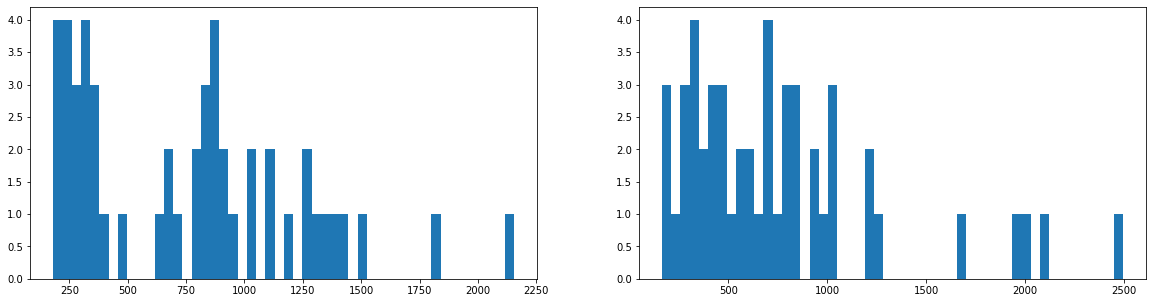

In [40]:
# get a general idea of the distribution of the reads

plt.figure(figsize = [20, 5]) 

plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
# for the distribution of the CNSL region reads of a sample
plt.hist(cnsl_data.iloc[3, 1:51], bins = 50);

plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
# for the distribution of the nonCNSL region reads of a sample
plt.hist(cnsl_data.iloc[3, 51:], bins = 50);

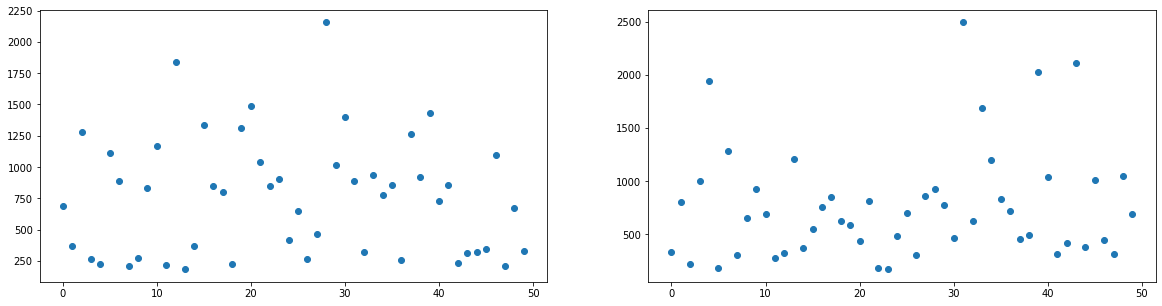

In [43]:
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 2
# for the distribution of the CNSL region reads of a sample
plt.scatter(x = np.arange(50), y = cnsl_data.iloc[3, 1:51]);

plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
# for the distribution of the nonCNSL region reads of a sample
plt.scatter(x = np.arange(50), y = cnsl_data.iloc[3, 51:]);

## Normalization by sample

Next, we can do some normalization based on the reads of the nonCNSL gene region. For each sample, the reads will be divided by the average of the reads for all of the probes on the nonCNSL gene region. After this normalization, the ratio of 1 will indicate CN = 2. Then a ratio of 0.5 indicates a deletion (CN = 1), and a ratio of 1.5 indicates a duplication (CN = 3).

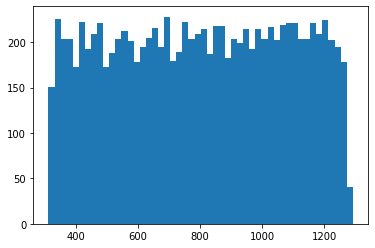

In [27]:
# the average of reads across all probes within the nonCNSL region for each sample
normalization_factor = np.mean(cnsl_data[list(cnsl_data)[51:]], axis = 1)
plt.hist(normalization_factor, bins = 50);

In [47]:
normalization_factor

0        444.62
1        581.68
2        561.94
3        764.14
4        716.72
         ...   
9995     558.34
9996    1111.54
9997     931.84
9998    1115.68
9999     929.58
Length: 10000, dtype: float64

In [55]:
cnsl_normalized = cnsl_data.copy()

In [56]:
cnsl_normalized.iloc[:,1:] = cnsl_normalized.iloc[:,1:].div(normalization_factor, axis = 0)

In [57]:
cnsl_normalized

,ethnicity,CNSL_probe_0,CNSL_probe_1,CNSL_probe_2,CNSL_probe_3,CNSL_probe_4,CNSL_probe_5,CNSL_probe_6,CNSL_probe_7,CNSL_probe_8,...,non_CNSL_probe_40,non_CNSL_probe_41,non_CNSL_probe_42,non_CNSL_probe_43,non_CNSL_probe_44,non_CNSL_probe_45,non_CNSL_probe_46,non_CNSL_probe_47,non_CNSL_probe_48,non_CNSL_probe_49
0,A,0.922136,0.524043,1.567631,0.375602,0.294634,0.173182,1.169538,0.296883,0.362107,...,1.299987,0.418335,0.521794,2.703432,0.584769,1.353965,0.530790,0.402591,1.331474,0.933381
1,C,0.957571,0.522624,1.643515,0.357585,0.237244,0.182231,1.165589,0.297414,0.374777,...,1.356416,0.306010,0.553569,2.802228,0.539816,1.340943,0.574199,0.374777,1.217164,1.000550
2,A,0.866641,0.462683,1.532192,0.345233,0.263373,0.167278,1.097982,0.339894,0.364808,...,1.354237,0.364808,0.596149,2.562551,0.510731,1.323985,0.528526,0.375485,1.235007,0.925366
3,B,0.897741,0.481587,1.669851,0.349412,0.289214,1.457848,1.156856,0.269584,0.357264,...,1.354464,0.404376,0.543094,2.759965,0.490748,1.319130,0.577119,0.412228,1.363624,0.905593
4,C,0.944581,0.485545,1.741266,0.372530,0.249749,0.373926,1.194330,0.313930,0.425550,...,1.321297,0.351602,0.537169,2.719333,0.505079,1.375712,0.546936,0.417178,1.229211,0.939000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,A,0.936705,0.522979,1.687144,0.385070,0.252534,0.085969,1.135509,0.308056,0.388652,...,1.346850,0.381488,0.505069,2.607730,0.522979,1.217896,0.531934,0.435219,1.284164,0.933123
9996,A,0.932040,0.446228,1.694046,0.327474,0.281591,0.072872,1.181244,0.297785,0.340069,...,1.301798,0.376055,0.522698,2.714252,0.522698,1.335085,0.573079,0.357162,1.265811,0.974324
9997,C,0.908954,0.461453,1.653717,0.394918,0.268286,0.771592,1.101047,0.328383,0.364870,...,1.327481,0.330529,0.488281,2.765496,0.524768,1.370407,0.591303,0.401356,1.338213,0.937929
9998,B,0.907966,0.543166,1.630396,0.389000,0.274272,0.025993,1.148179,0.342392,0.407823,...,1.260218,0.378245,0.535100,2.793812,0.530618,1.300552,0.538685,0.428438,1.306826,0.909759


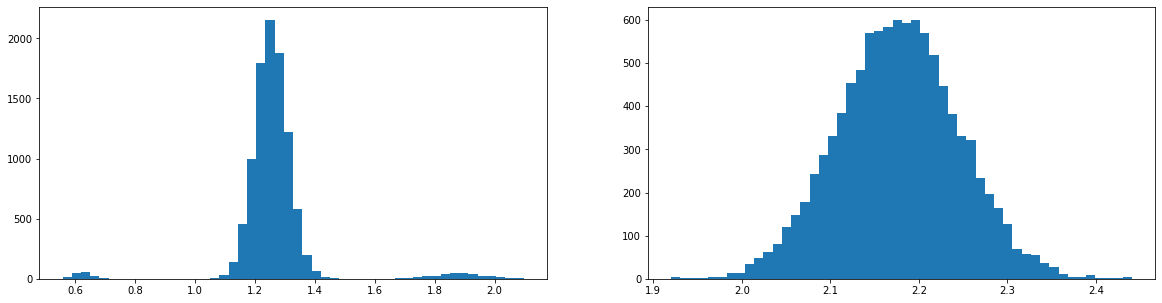

In [62]:
# after normalization
# get a general idea of the distribution of the reads

# for a particular probe
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 1
# for the distribution of a probe in the CNSL region
plt.hist(cnsl_normalized['CNSL_probe_33'], bins = 50);

plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
# for the distribution of a probe in the nonCNSL region
plt.hist(cnsl_normalized['non_CNSL_probe_33'], bins = 50);

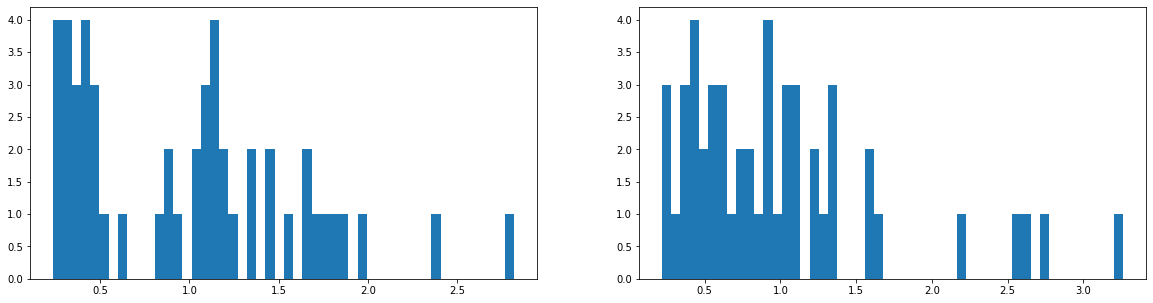

In [60]:
# after normalization
# get a general idea of the distribution of the reads

# for a particular sample
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
# for the distribution of the CNSL region reads of a sample
plt.hist(cnsl_normalized.iloc[3, 1:51], bins = 50);

plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
# for the distribution of the nonCNSL region reads of a sample
plt.hist(cnsl_normalized.iloc[3, 51:], bins = 50);

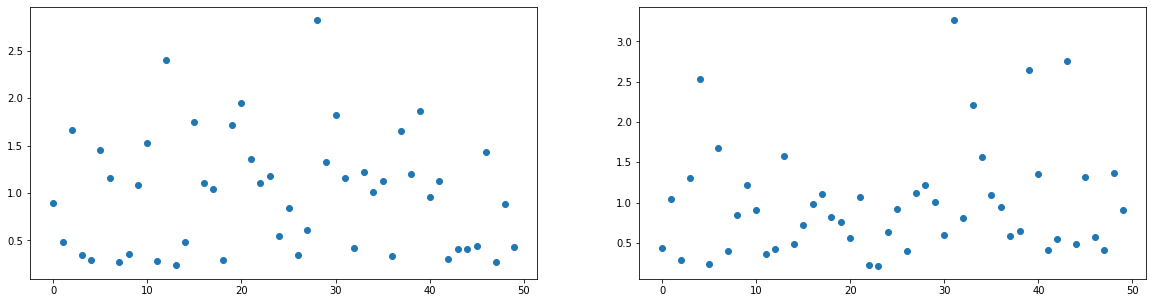

In [61]:
# after normalization
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 2
# for the distribution of the CNSL region reads of a sample
plt.scatter(x = np.arange(50), y = cnsl_normalized.iloc[3, 1:51]);

plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
# for the distribution of the nonCNSL region reads of a sample
plt.scatter(x = np.arange(50), y = cnsl_normalized.iloc[3, 51:]);

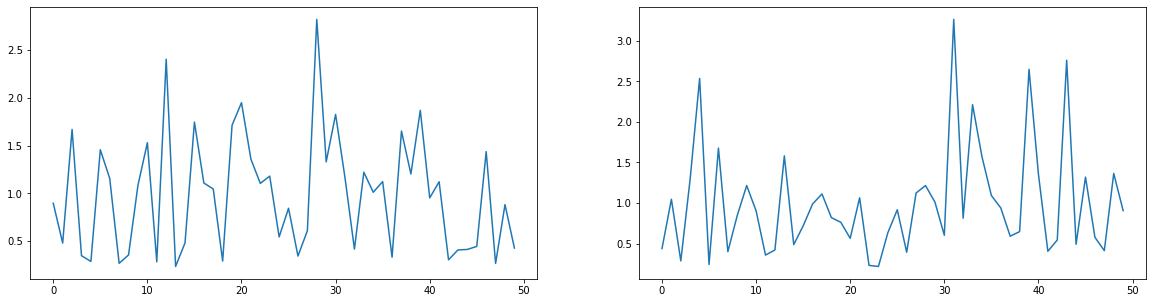

In [66]:
# line chart
# after normalization
# for a particular sample
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 2
# for the distribution of the CNSL region reads of a sample
plt.errorbar(x = np.arange(50), y = cnsl_normalized.iloc[3, 1:51]);

plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
# for the distribution of the nonCNSL region reads of a sample
plt.errorbar(x = np.arange(50), y = cnsl_normalized.iloc[3, 51:]);

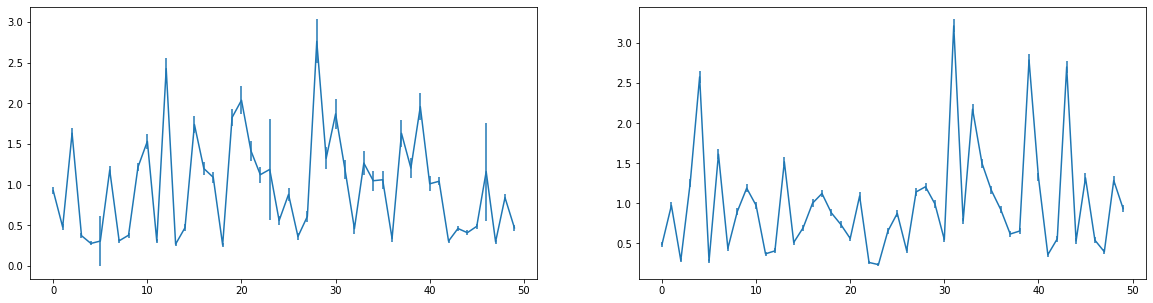

In [65]:
# after normalization
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 2
# for the distribution of the CNSL region reads of a sample
y_mean = np.mean(cnsl_normalized.iloc[:, 1:51], axis = 0)
y_std = np.std(cnsl_normalized.iloc[:, 1:51], axis = 0)
plt.errorbar(x=np.arange(50), y=y_mean, yerr=y_std);

plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
# for the distribution of the CNSL region reads of a sample
y_mean = np.mean(cnsl_normalized.iloc[:, 51:], axis = 0)
y_std = np.std(cnsl_normalized.iloc[:, 51:], axis = 0)
plt.errorbar(x=np.arange(50), y=y_mean, yerr=y_std);

# Should we also normalize for the probes??

## Normalization by probe


Next, we can do some normalization for each probe. For each probe, the reads will be divided by the average of the reads for all of the samples for that particular probe. After this normalization, the ratio of 1 will indicate CN = 2. Then a ratio of 0.5 indicates a deletion (CN = 1), and a ratio of 1.5 indicates a duplication (CN = 3).

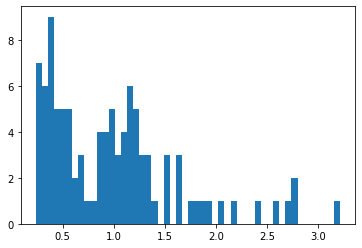

In [69]:
# the average of reads across all probes within the nonCNSL region for each sample
normalization_factor_probe = np.mean(cnsl_normalized[list(cnsl_normalized)[1:]], axis = 0)
plt.hist(normalization_factor_probe, bins = 50);

In [70]:
normalization_factor_probe

CNSL_probe_0         0.924823
CNSL_probe_1         0.479238
CNSL_probe_2         1.632993
CNSL_probe_3         0.372863
CNSL_probe_4         0.277288
                       ...   
non_CNSL_probe_45    1.319465
non_CNSL_probe_46    0.540860
non_CNSL_probe_47    0.396115
non_CNSL_probe_48    1.286132
non_CNSL_probe_49    0.934342
Length: 100, dtype: float64

In [71]:
cnsl_normalized_2 = cnsl_normalized.copy()

In [72]:
cnsl_normalized_2.iloc[:,1:] = cnsl_normalized_2.iloc[:,1:].div(normalization_factor_probe, axis = 1)

In [73]:
cnsl_normalized_2

,ethnicity,CNSL_probe_0,CNSL_probe_1,CNSL_probe_2,CNSL_probe_3,CNSL_probe_4,CNSL_probe_5,CNSL_probe_6,CNSL_probe_7,CNSL_probe_8,...,non_CNSL_probe_40,non_CNSL_probe_41,non_CNSL_probe_42,non_CNSL_probe_43,non_CNSL_probe_44,non_CNSL_probe_45,non_CNSL_probe_46,non_CNSL_probe_47,non_CNSL_probe_48,non_CNSL_probe_49
0,A,0.997094,1.093492,0.959974,1.007345,1.062555,0.564914,0.991478,0.959378,0.956826,...,0.978985,1.164922,0.935729,0.999863,1.100977,1.026147,0.981381,1.016348,1.035255,0.998972
1,C,1.035410,1.090531,1.006444,0.959025,0.855587,0.594432,0.988130,0.961096,0.990304,...,1.021480,0.852136,0.992711,1.036402,1.016341,1.016279,1.061640,0.946130,0.946376,1.070861
2,A,0.937088,0.965455,0.938272,0.925897,0.949819,0.545655,0.930816,1.098369,0.963962,...,1.019840,1.015867,1.069069,0.947758,0.961581,1.003426,0.977195,0.947919,0.960249,0.990393
3,B,0.970717,1.004902,1.022571,0.937107,1.043010,4.755461,0.980727,0.871163,0.944030,...,1.020010,1.126052,0.973926,1.020772,0.923958,0.999746,1.067039,1.040677,1.060252,0.969231
4,C,1.021364,1.013161,1.066303,0.999108,0.900684,1.219735,1.012495,1.014467,1.124467,...,0.995033,0.979093,0.963301,1.005744,0.950939,1.042629,1.011233,1.053174,0.955742,1.004985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,A,1.012848,1.091271,1.033161,1.032739,0.910730,0.280429,0.962629,0.995485,1.026969,...,1.014276,1.062316,0.905735,0.964468,0.984641,0.923023,0.983496,1.098717,0.998470,0.998695
9996,A,1.007804,0.931119,1.037387,0.878268,1.015520,0.237706,1.001402,0.962294,0.898593,...,0.980349,1.047187,0.937350,1.003865,0.984113,1.011838,1.059569,0.901662,0.984200,1.042791
9997,C,0.982842,0.962888,1.012691,1.059149,0.967537,2.516911,0.933415,1.061170,0.964126,...,0.999690,0.920412,0.875631,1.022817,0.988010,1.038608,1.093264,1.013232,1.040494,1.003839
9998,B,0.981773,1.133396,0.998409,1.043280,0.989124,0.084789,0.973370,1.106442,1.077626,...,0.949036,1.053285,0.959590,1.033290,0.999024,0.985667,0.995978,1.081600,1.016090,0.973689


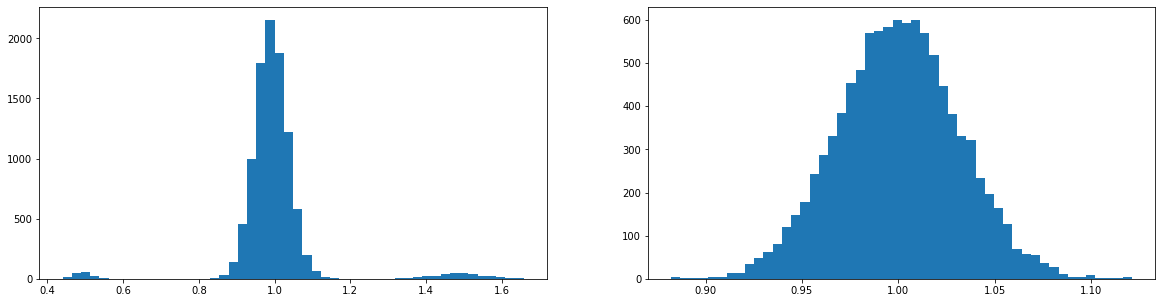

In [74]:
# after normalization
# get a general idea of the distribution of the reads

# for a particular probe
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 1
# for the distribution of a probe in the CNSL region
plt.hist(cnsl_normalized_2['CNSL_probe_33'], bins = 50);

plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
# for the distribution of a probe in the nonCNSL region
plt.hist(cnsl_normalized_2['non_CNSL_probe_33'], bins = 50);

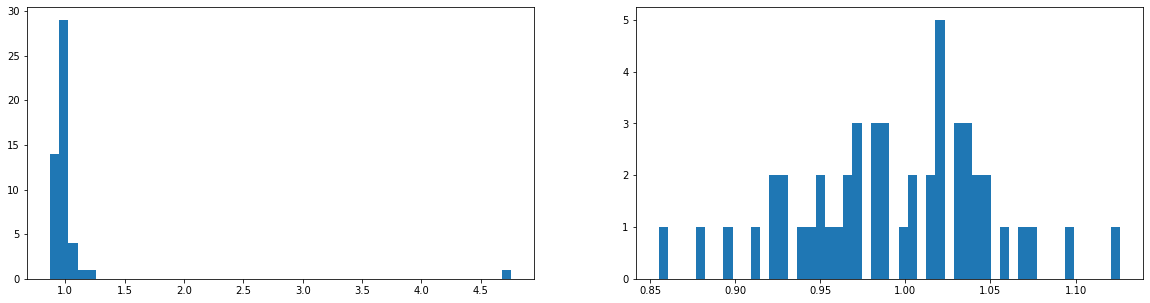

In [75]:
# after normalization
# get a general idea of the distribution of the reads

# for a particular sample
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
# for the distribution of the CNSL region reads of a sample
plt.hist(cnsl_normalized_2.iloc[3, 1:51], bins = 50);

plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
# for the distribution of the nonCNSL region reads of a sample
plt.hist(cnsl_normalized_2.iloc[3, 51:], bins = 50);

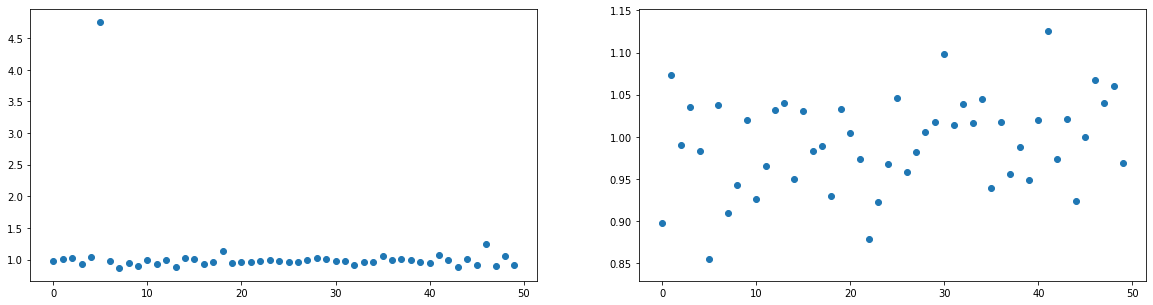

In [76]:
# after normalization
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 2
# for the distribution of the CNSL region reads of a sample
plt.scatter(x = np.arange(50), y = cnsl_normalized_2.iloc[3, 1:51]);

plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
# for the distribution of the nonCNSL region reads of a sample
plt.scatter(x = np.arange(50), y = cnsl_normalized_2.iloc[3, 51:]);

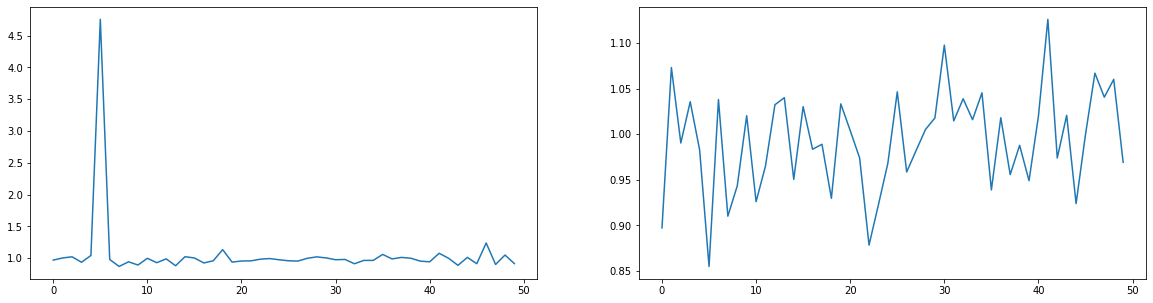

In [82]:
def check_sample(data, n):
    # line chart
    # after normalization
    # for a particular sample
    plt.figure(figsize = [20, 5]) 

    plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 2
    # for the distribution of the CNSL region reads of a sample
    plt.errorbar(x = np.arange(50), y = data.iloc[n, 1:51]);

    plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
    # for the distribution of the nonCNSL region reads of a sample
    plt.errorbar(x = np.arange(50), y = data.iloc[n, 51:]);
    
check_sample(cnsl_normalized_2, 3)

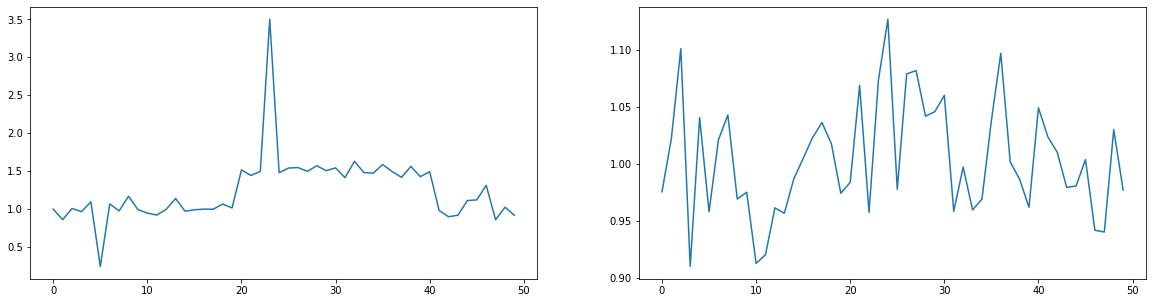

In [105]:
check_sample(cnsl_normalized_2, 24)

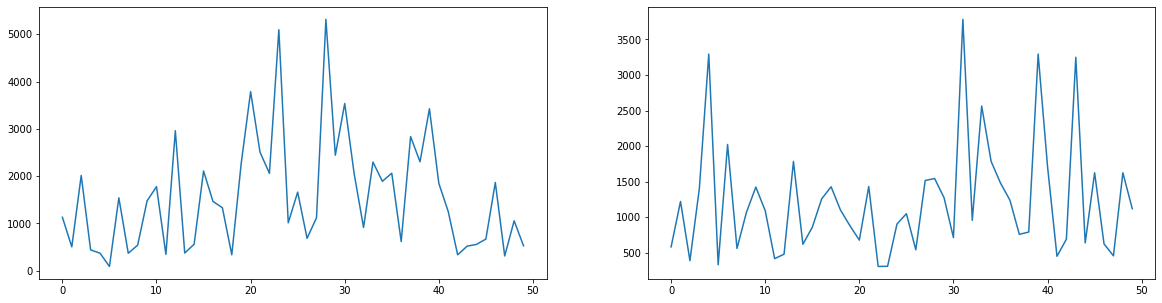

In [106]:
check_sample(cnsl_data, 24)

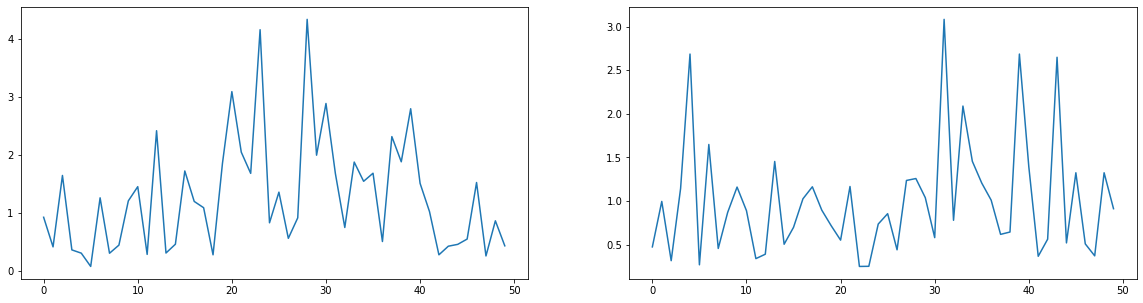

In [107]:
check_sample(cnsl_normalized, 24)

In [932]:
i = 799

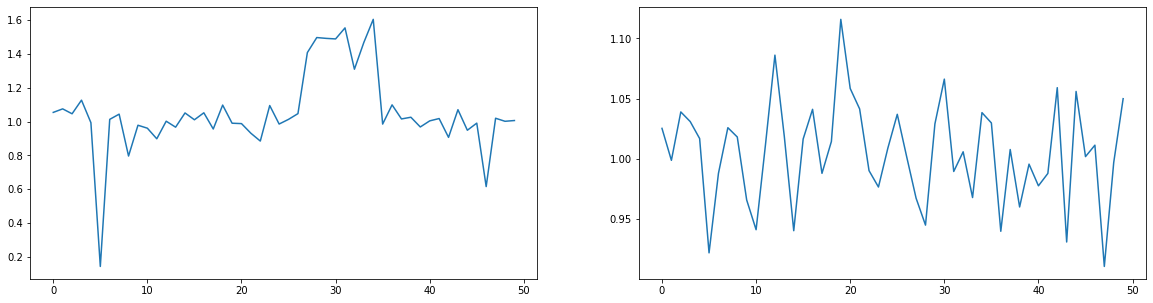

In [933]:
check_sample(cnsl_normalized_2, i)
i += 1

In [927]:
i

801

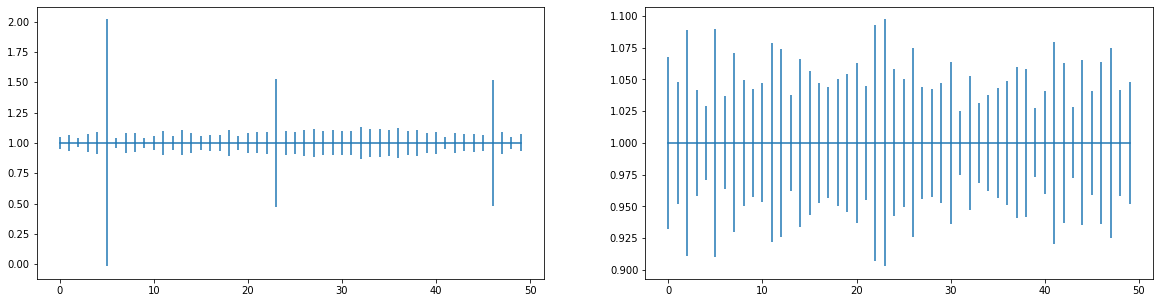

In [78]:
# after normalization
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 2
# for the distribution of the CNSL region reads of a sample
y_mean = np.mean(cnsl_normalized_2.iloc[:, 1:51], axis = 0)
y_std = np.std(cnsl_normalized_2.iloc[:, 1:51], axis = 0)
plt.errorbar(x=np.arange(50), y=y_mean, yerr=y_std);

plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
# for the distribution of the CNSL region reads of a sample
y_mean = np.mean(cnsl_normalized_2.iloc[:, 51:], axis = 0)
y_std = np.std(cnsl_normalized_2.iloc[:, 51:], axis = 0)
plt.errorbar(x=np.arange(50), y=y_mean, yerr=y_std);

We can see that some of the probes in the CNSL gene region have super high variation which might interfere the calling of duplications or deletions. So we need to remove these 3 probematic probes.

In [939]:
# CNSL_probe_5, _23, _46
cnsl_std = np.std(cnsl_normalized_2.iloc[:, 1:51], axis = 0) 
(cnsl_std[cnsl_std > 0.2]).index

Index(['CNSL_probe_5', 'CNSL_probe_23', 'CNSL_probe_46'], dtype='object')

In [954]:
bad_prob_ind = np.where(cnsl_std > 0.2)

In [945]:
# drop the problematic probes
cnsl_clean = cnsl_normalized_2.drop((cnsl_std[cnsl_std > 0.2]).index, axis = 1)

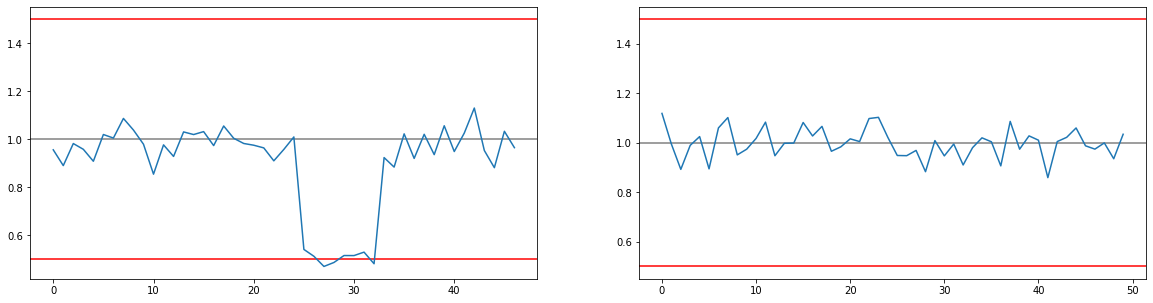

In [953]:
def check_sample_2(data, n):
    # line chart
    # after normalization
    # for a particular sample
    plt.figure(figsize = [20, 5]) 

    plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 2
    # for the distribution of the CNSL region reads of a sample
    plt.errorbar(x = np.arange(47), y = data.iloc[n, 1:48]);
    plt.axhline(y = 1, color = 'grey');
    plt.axhline(y = 1.5, color = 'red');
    plt.axhline(y = 0.5, color = 'red');
    
    plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
    # for the distribution of the nonCNSL region reads of a sample
    plt.errorbar(x = np.arange(50), y = data.iloc[n, 48:]);
    plt.axhline(y = 1, color = 'grey');
    plt.axhline(y = 1.5, color = 'red');
    plt.axhline(y = 0.5, color = 'red');

check_sample_2(cnsl_clean, 163)

Next, we can write a function to call out the duplications and deletions.
- The breakpoint positions are known in the literature and correspond to the following probe locations:
    - 32-38
    - 27-34
    - 20-40
    - 10-40

In [959]:
def variation_calling(data, n):
    signal_array = data.iloc[n, 1:51]
    result = check_breakpoint(signal_array, 10, 40)
    if result:
        return result + "_10"
    result = check_breakpoint(signal_array, 20, 40)
    if result:
        return result + "_20"    
    result = check_breakpoint(signal_array, 27, 34)
    if result:
        return result + "_27" 
    result = check_breakpoint(signal_array, 32, 38)
    if result:
        return result + "_32" 
    return "wt"
    
    
def check_breakpoint(signal_array, u, d):
    ind = np.setdiff1d(np.arange(u, d+1), bad_prob_ind)
    signal_mean = np.mean(signal_array[ind])
    if abs(signal_mean - 1.5) < 0.15:
        return "duplication"
    elif abs(signal_mean - 0.5) < 0.15:
        return "deletion"
    else:
        return

# test the function:
variation_calling(cnsl_normalized_2, 234)

'deletion_20'

In [961]:
annotation = []
for i in range(cnsl_normalized_2.shape[0]):
    annotation.append(variation_calling(cnsl_normalized_2, i))
cnsl_clean["annotation"] = annotation

In [962]:
cnsl_clean

,ethnicity,CNSL_probe_0,CNSL_probe_1,CNSL_probe_2,CNSL_probe_3,CNSL_probe_4,CNSL_probe_6,CNSL_probe_7,CNSL_probe_8,CNSL_probe_9,...,non_CNSL_probe_41,non_CNSL_probe_42,non_CNSL_probe_43,non_CNSL_probe_44,non_CNSL_probe_45,non_CNSL_probe_46,non_CNSL_probe_47,non_CNSL_probe_48,non_CNSL_probe_49,annotation
0,A,0.997094,1.093492,0.959974,1.007345,1.062555,0.991478,0.959378,0.956826,1.026968,...,1.164922,0.935729,0.999863,1.100977,1.026147,0.981381,1.016348,1.035255,0.998972,wt
1,C,1.035410,1.090531,1.006444,0.959025,0.855587,0.988130,0.961096,0.990304,1.015531,...,0.852136,0.992711,1.036402,1.016341,1.016279,1.061640,0.946130,0.946376,1.070861,wt
2,A,0.937088,0.965455,0.938272,0.925897,0.949819,0.930816,1.098369,0.963962,1.014603,...,1.015867,1.069069,0.947758,0.961581,1.003426,0.977195,0.947919,0.960249,0.990393,wt
3,B,0.970717,1.004902,1.022571,0.937107,1.043010,0.980727,0.871163,0.944030,0.893630,...,1.126052,0.973926,1.020772,0.923958,0.999746,1.067039,1.040677,1.060252,0.969231,wt
4,C,1.021364,1.013161,1.066303,0.999108,0.900684,1.012495,1.014467,1.124467,0.967678,...,0.979093,0.963301,1.005744,0.950939,1.042629,1.011233,1.053174,0.955742,1.004985,wt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,A,1.012848,1.091271,1.033161,1.032739,0.910730,0.962629,0.995485,1.026969,0.948943,...,1.062316,0.905735,0.964468,0.984641,0.923023,0.983496,1.098717,0.998470,0.998695,wt
9996,A,1.007804,0.931119,1.037387,0.878268,1.015520,1.001402,0.962294,0.898593,1.050292,...,1.047187,0.937350,1.003865,0.984113,1.011838,1.059569,0.901662,0.984200,1.042791,wt
9997,C,0.982842,0.962888,1.012691,1.059149,0.967537,0.933415,1.061170,0.964126,0.963244,...,0.920412,0.875631,1.022817,0.988010,1.038608,1.093264,1.013232,1.040494,1.003839,wt
9998,B,0.981773,1.133396,0.998409,1.043280,0.989124,0.973370,1.106442,1.077626,1.053031,...,1.053285,0.959590,1.033290,0.999024,0.985667,0.995978,1.081600,1.016090,0.973689,wt


In [964]:
cnsl_clean["annotation"].value_counts()

wt                9523
duplication_20     125
duplication_10      76
duplication_32      63
duplication_27      61
deletion_32         57
deletion_27         55
deletion_20         25
deletion_10         15
Name: annotation, dtype: int64

In [965]:
ethnicity_variation = cnsl_clean[["ethnicity", "annotation"]]

In [966]:
ethnicity_variation

,ethnicity,annotation
0,A,wt
1,C,wt
2,A,wt
3,B,wt
4,C,wt
...,...,...
9995,A,wt
9996,A,wt
9997,C,wt
9998,B,wt


In [970]:
# Series
ethnicity_variation.groupby(["ethnicity", "annotation"]).size()

ethnicity  annotation    
A          deletion_27         55
           deletion_32         57
           duplication_27      61
           duplication_32      63
           wt                4752
B          deletion_10          1
           deletion_20         25
           duplication_10       7
           duplication_20     125
           wt                2385
C          deletion_10         14
           duplication_10      69
           wt                2386
dtype: int64

In [971]:
# data frame
ethnicity_variation.groupby(["ethnicity", "annotation"]).size().reset_index(name='counts')

,ethnicity,annotation,counts
0,A,deletion_27,55
1,A,deletion_32,57
2,A,duplication_27,61
3,A,duplication_32,63
4,A,wt,4752
5,B,deletion_10,1
6,B,deletion_20,25
7,B,duplication_10,7
8,B,duplication_20,125
9,B,wt,2385
